## **Procesar el Json de `fichas_tecnicas_mapped.json` para poder trabajar con Chatbots**

---
### **Librerías**

In [21]:
import json
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
#import utils
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

---
### **1. Procesar JSON para modelo de embeddings**

---
#### **1.1 Load Data**

In [5]:
# Ruta del archivo JSON (ajusta la ruta si es necesario)
json_path = "../../data/outputs/2_data_preprocessing/fichas_tecnicas_mapped_atc.json"

# Cargar el JSON
with open(json_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Mostrar los primeros elementos para revisar la estructura
print(
    json.dumps(data[:2], indent=4, ensure_ascii=False)
)  # Mostramos solo 2 para no saturar

[
    {
        "indicaciones": "en base a su efecto antiagregante plaquetario está indicado en la profilaxis de: infarto de miocardio o reinfarto de miocardio en pacientes con angina de pecho inestable y para prevenir la recurrencia del mismo en pacientes con historia de infarto de miocardio. prevención de la oclusión del bypass aortocoronario. tromboflebitis, flebotrombosis y riesgo de trombosis arteriales. tromboembolismo post-operatorio en pacientes con prótesis vasculares biológicas o con shunts arteriovenosos. tratamiento de ataques isquémicos transitorios en varones con isquemia cerebral transitoria para reducir el riesgo de accidente cerebrovascular. estas indicaciones requieren siempre un control médico.",
        "posologia": "posología: como inhibidor de la agregación plaquetaria: en la prevención de accidentes tromboembólicos (infarto, angina de pecho, prótesis valvulares biológicas, by pass arteriales, tromboflebitis, flebotrombosis y riesgo de trombosis arterial). dosis m

In [6]:
# Mostrar todas las claves de un solo medicamento para entender la estructura
print("Claves disponibles en el JSON:")
print(list(data[0].keys()))

Claves disponibles en el JSON:
['indicaciones', 'posologia', 'contraindicaciones', 'advertencias', 'interacciones', 'fertilidad_embarazo', 'efectos_conducir', 'reacciones_adversas', 'sobredosis', 'ATC', 'Propiedades_farmacocineticas', 'excipientes', 'incompatibilidades', 'precauciones_conservacion', 'fecha_revision', 'nombre_medicamento', 'ATC_Nivel_Anatomico', 'Descripcion_Nivel_Anatomico', 'ATC_Nivel_2_Subgrupo_Terapeutico', 'Descripcion_Nivel_2_Subgrupo_Terapeutico', 'ATC_Nivel_3_Subgrupo_Terapeutico_Farmacologico', 'Descripcion_Nivel_3_Subgrupo_Terapeutico_Farmacologico', 'ATC_Nivel_4_Subgrupo_Terapeutico_Farmacologico_Quimico', 'Descripcion_Nivel_4_Subgrupo_Terapeutico_Farmacologico_Quimico', 'ATC_Nivel_5_Principio_Activo', 'Descripcion_Nivel_5_Principio_Activo']


---
#### **1.2 Convertir el JSON en fragmentos**

Queremos convertir el JSON inicial a una estructura tal que así:

```python
[
    {
        "medicamento": "Ácido acetilsalicílico",
        "categoria": "indicaciones",
        "texto": "En base a su efecto antiagregante plaquetario está indicado en..."
    },
    {
        "medicamento": "Ácido acetilsalicílico",
        "categoria": "advertencias",
        "texto": "Dado el efecto antiagregante plaquetario del ácido acetilsalicílico..."
    },
    ...
]
```

In [7]:
# Generar lista de fragmentos para el chatbot
# Esta celda recorre cada medicamento del JSON y extrae los campos de interés.
# Si el valor de un campo es None, se reemplaza por una cadena vacía.
# Se elimina la extensión ".txt" del campo "nombre_archivo" para obtener el nombre del medicamento.

# Lista donde almacenaremos los fragmentos
fragments = []

# Definimos los campos de interés que queremos extraer
campos_interes = [
    "indicaciones",
    "posologia",
    "contraindicaciones",
    "advertencias",
    "interacciones",
    "fertilidad_embarazo",
    "efectos_conducir",
    "reacciones_adversas",
    "sobredosis",
    "Propiedades_farmacocineticas",
    "excipientes",
    "incompatibilidades",
    "precauciones_conservacion",
]

# Recorremos cada medicamento en el JSON
for medicamento in data:
    # Extraer el nombre del medicamento desde "nombre_archivo" y quitar la extensión ".txt"
    nombre_medicamento = medicamento.get("nombre_archivo", "Desconocido").replace(
        ".txt", ""
    )

    # Iteramos sobre cada campo de interés
    for campo in campos_interes:
        # Obtener el valor del campo; si es None, lo reemplazamos por una cadena vacía
        valor = medicamento.get(campo)
        if valor is None:
            texto = ""
        else:
            texto = valor.strip()  # Eliminamos espacios en blanco innecesarios

        # Solo añadimos el fragmento si hay contenido en el campo (no vacío)
        if texto:
            fragments.append(
                {
                    "medicamento": nombre_medicamento,  # Nombre del medicamento sin ".txt"
                    "categoria": campo,  # Categoría (por ejemplo, "indicaciones", "advertencias", etc.)
                    "texto": texto,  # Contenido del campo
                }
            )

# Mostrar algunos ejemplos de fragmentos generados para verificar la estructura
print("Ejemplo de fragmentos generados:")
print(json.dumps(fragments[:5], indent=4, ensure_ascii=False))

Ejemplo de fragmentos generados:
[
    {
        "medicamento": "Desconocido",
        "categoria": "indicaciones",
        "texto": "en base a su efecto antiagregante plaquetario está indicado en la profilaxis de: infarto de miocardio o reinfarto de miocardio en pacientes con angina de pecho inestable y para prevenir la recurrencia del mismo en pacientes con historia de infarto de miocardio. prevención de la oclusión del bypass aortocoronario. tromboflebitis, flebotrombosis y riesgo de trombosis arteriales. tromboembolismo post-operatorio en pacientes con prótesis vasculares biológicas o con shunts arteriovenosos. tratamiento de ataques isquémicos transitorios en varones con isquemia cerebral transitoria para reducir el riesgo de accidente cerebrovascular. estas indicaciones requieren siempre un control médico."
    },
    {
        "medicamento": "Desconocido",
        "categoria": "posologia",
        "texto": "posología: como inhibidor de la agregación plaquetaria: en la prevención

---
### **2. Generación de embeddings con el modelo `Sentence Transformers`**

En esta fase, utilizamos el modelo preentrenado all-MiniLM-L6-v2 para transformar cada fragmento de nuestro JSON en un vector numérico (embedding). Estos embeddings capturan la semántica del texto, lo que nos permite realizar búsquedas basadas en similitud y establecer relaciones entre fragmentos.

Nuestro JSON enriquecido con embeddings funciona como una base de datos vectorial. Esto es esencial en un pipeline de Retrieval-Augmented Generation (RAG), donde se recupera la información relevante y se utiliza como contexto para generar respuestas.

Modelo Generativo Recomendado para el Chatbot
Para la parte generativa del chatbot, recomendamos utilizar un modelo diseñado para integrarse en arquitecturas RAG. Algunas opciones compatibles son:

Facebook RAG-Token (facebook/rag-token-nq):
Diseñado específicamente para integrar recuperación y generación, aprovechando embeddings semánticos.

Flan-T5 o Llama2:
Pueden ser fine-tuned para tareas de RAG y ofrecen excelentes resultados en generación de respuestas.

In [8]:
# Configuramos PyTorch para usar un número mayor de hilos (ajusta según tu CPU)
torch.set_num_threads(8)  # Por ejemplo, usar 8 hilos (8 cores)

# Cargamos el modelo preentrenado 'all-MiniLM-L6-v2'
model = SentenceTransformer("all-MiniLM-L6-v2")

# Extraemos el texto de cada fragmento
texts = [frag["texto"] for frag in fragments]

# Generamos los embeddings para cada fragmento, aumentando el batch_size para optimizar el procesamiento
embeddings = model.encode(
    texts, convert_to_numpy=True, show_progress_bar=True, batch_size=64
)

# Mostramos la dimensión de los embeddings para confirmar que se han generado correctamente
print("Número de fragmentos:", len(texts))
print("Dimensión de cada embedding:", embeddings.shape[1])

Batches: 100%|██████████| 3998/3998 [23:31<00:00,  2.83it/s]


Número de fragmentos: 255840
Dimensión de cada embedding: 384


In [ ]:
# Guardamos el array de embeddings en un archivo .npy
output_path = "../../data/outputs/5_chatbot/embeddings.npy"
np.save(output_path, embeddings)

Forma del array de embeddings: (255840, 384)
Primeras 5 filas del array de embeddings:
[[-0.07136275 -0.05918246 -0.05509703 ...  0.03421235  0.1379857
  -0.07116101]
 [ 0.0209854   0.01761444 -0.03261471 ...  0.07995179  0.03853668
  -0.04150769]
 [ 0.01360057 -0.04719002 -0.14827095 ... -0.01077812  0.08297174
   0.04240505]
 [-0.0306806  -0.04917139 -0.06687324 ...  0.003047    0.08923826
   0.02213486]
 [-0.00627262 -0.08888327 -0.07965814 ... -0.01347708  0.03768596
   0.05125593]]

Análisis del espacio de embeddings:
Cada vector de embedding es una representación numérica del texto obtenido a partir del modelo de SentenceTransformer.
Cada dimensión en este vector es una característica latente aprendida durante el entrenamiento del modelo,
capaz de captar aspectos semánticos y contextuales del lenguaje. Estas dimensiones no tienen una interpretación
directa como 'la dimensión 1 representa X', sino que en conjunto forman un espacio latente que captura la semántica.

Varianza explic

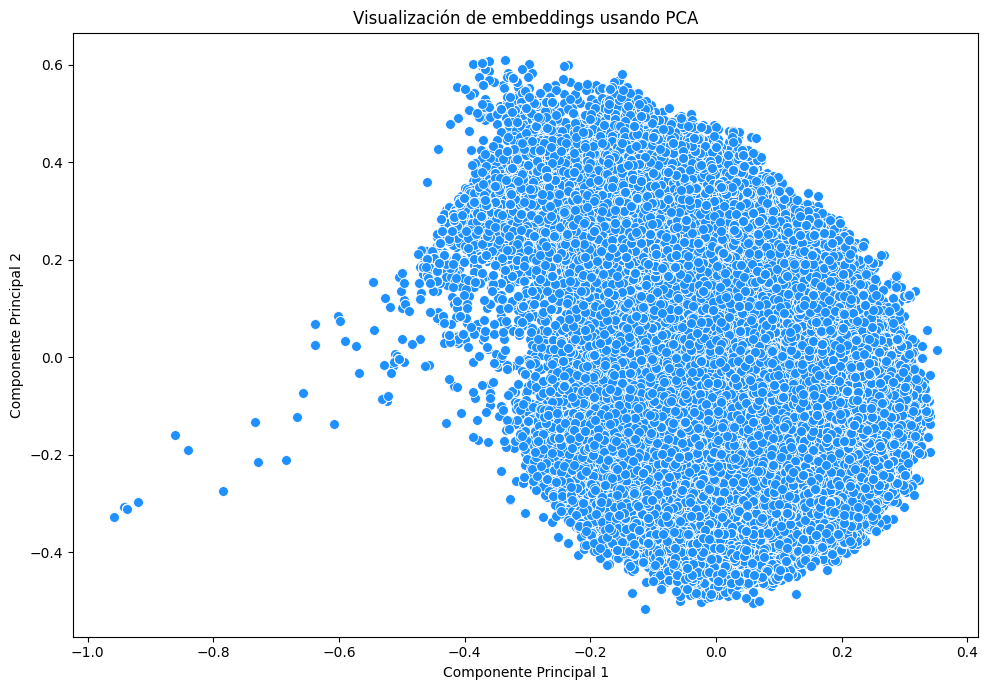

In [24]:
# 1. Cargar y comprobar la forma del array de embeddings
embeddings = np.load(output_path)
print("Forma del array de embeddings:", embeddings.shape)

# 2. Mostrar las primeras 5 filas del array
print("Primeras 5 filas del array de embeddings:")
print(embeddings[:5])

# 3. Explicación sobre lo que representa cada vector de embedding
print("\nAnálisis del espacio de embeddings:")
print("Cada vector de embedding es una representación numérica del texto obtenido a partir del modelo de SentenceTransformer.")
print("Cada dimensión en este vector es una característica latente aprendida durante el entrenamiento del modelo,")
print("capaz de captar aspectos semánticos y contextuales del lenguaje. Estas dimensiones no tienen una interpretación")
print("directa como 'la dimensión 1 representa X', sino que en conjunto forman un espacio latente que captura la semántica.")

# 4. Visualización del espacio de embeddings mediante PCA
# Reducimos a 2 dimensiones para graficar
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Imprimir la varianza explicada por cada componente principal
print("\nVarianza explicada por cada componente principal:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Componente {i+1}: {var*100:.2f}%")

plt.figure(figsize=(10,7))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], s=50, color='dodgerblue')
plt.title("Visualización de embeddings usando PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.tight_layout()
plt.show()

# Comentarios adicionales:
# - La forma del array indica el número total de documentos y la dimensión de cada embedding.
# - Cada posición en un embedding es una característica latente sin significado directo individual, pero su combinación
#   permite una representación semántica del texto.
# - La reducción a dos dimensiones mediante PCA permite identificar las direcciones que capturan mayor varianza,
#   lo cual ayuda a interpretar qué tan dispersos o agrupados están los textos en el espacio latente.
# - Técnicas adicionales como t-SNE o UMAP pueden complementarse para analizar agrupaciones semánticas en los datos.